# On Reliability and Economics

## **Jed Brown**, CU Boulder
### Collaborators: Zach Atkins, Valeria Barra, Natalie Beams, Fabio Di Gioacchino, Leila Ghaffari, Ken Jansen, Matthew Knepley, William Moses, Rezgar Shakeri, Karen Stengel, Jeremy L. Thompson, James Wright III, Junchao Zhang


## Numerical Analysis of Multiphysics Problems, ICERM, 2024-02-13

In [2]:
from IPython.display import SVG, Video, HTML, IFrame
import pandas as pd
import altair as alt
from io import StringIO
import numpy as np

import base64
from IPython.display import Image, display
#import matplotlib.pyplot as plt

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(
    Image(
      url="https://mermaid.ink/img/"
      + base64_string
    )
  )

# Model selection is complicated

In [20]:
mm("""
mindmap
  root((linear elasticity))
    StVenant Kirchhoff
    small strain neo Hookean
    neo Hookean
      Mooney Rivlin
      Ogden
    additive plasticity
      logarithmic strain additive plasticity
        multiplicative plasticity
""")

* Post-hoc check that emergent structure stays in the simpler regime at the desired accuracy tolerance.
* Snap-through can happen at very small strains.
* Need to maintain a lot of drivers to optimize for each "simpler" model.

# What fluids model should we use?

In [22]:
mm("""
mindmap
  root((incompressible Stokes))
    incompressible NS
      RANS
      LES
      Boussinesq
    compressible Euler
      compressible NS
        RANS
        LES
""")

## Rule of thumb: incompressible and compressible are "the same" for $\mathrm{Ma} \lesssim 0.2$

# A2e High Fidelity Modeling (2015)

<img src="figures/fluids/A2e-decision-process-overview.png" width="90%" class="center" />

# Uzun and Malik (2022) artificially increase Ma=0.1 to Ma=0.2 to reduce stiffness

<img src="figures/fluids/UzunMalik-BumpVorticity-2022.png" width="90%" class="center" />

# "Structured grids are simpler"

* Uli Rüde claims 100x more efficient
  * Performance models: 🤨

## Engineering problems almost always need non-uniform resolution
* Tree- or patch-based AMR
* Overset grids

# Why all the "simpler" models?

* Cost
* Specification of boundary conditions, ...
* Tradition?

## Catch

* You still need to implement the sophisticated models for all-deformation structures, all-speed flow, etc.
* Multi-block/overset grid generation is poorly automated.
* Sometimes simple is stiffer (e.g., infinite acoustic speed for incompressible flow)

# What if "simple" is actually more complicated and no faster?

## Conjecture: Hyperelasticity at small strain is same efficiency as linear elasticity.
* Newton converges in 1 iteration if you were correct that the linear regime is valid.
* Exact reference frame invariance

## Conjecture: Low-Mach compressible flow is same efficiency as incompressible flow.

* Finite $\mathrm{Ma}$ makes pressure more local; allow looser tolerance in implicit integration.
* Boundary conditions admittedly more subtle.

## Conjecture: Structured grids are dead

* unstructured is faster, even for box-like domains
* quadratic/cubic elements are enough to amortize cost of unstructured connectivity

## Conjecture: Explicit time integration is over

* even "non-stiff" wave propagation rarely matches CFL globally for heterogeneous materials (e.g., seismic waves in the Earth; mesh design is hard)
* implicit admits discretizations with better dispersion properties

<img src="figures/portlandia-explicit-time-integration-over.jpg" />

# David Keyes, "Petaflop/s, seriously" (ca. 2007)

<img src="figures/Keyes-PeanutButter-2008.png" class="center" />

# Constants matter

## Relative cost of compute versus memory access
## Accuracy tolerances depend on application
## GPU vs CPU latencies
## Accuracy or conservation? Unbiased or biased error?

<img src="figures/app-perf-cartoon-2.png" width="100%" />

# Nonlinear solid mechanics


<video src="figures/ratel/schwarz-q2-5x5x5-t20-l2-r2.webm" width="90%" autoplay controls loop />

## Industrial state of practice

* Low order finite elements: $Q_1$ (trilinear) hexahedra, $P_2$ (quadratic) tetrahedra.
* Assembled matrices, sparse direct and algebraic multigrid solvers

## Myths

* High order doesn't help because real problems have singularities.
* Matrix-free methods are just for high order problems

<video src="figures/ratel/tire-platen.webm" autoplay loop width="100%" />

# Industrial models are riddled with singularities

<img src="figures/Bhardwaj-2002-assembly.png" width="80%" />

* Every reentrant corner
* Every Dirichlet (fixed/clamped) to Neumann boundary transitien


(From Bhardwaj et al, 2002.)

# The mathematician's way: $hp$ adaptive finite elements

Elliptic PDE always have singularities at reentrant corners (and Dirichlet to Neumann boundary transitions).

<img src="https://www.dealii.org/images/steps/developer/step-27-solution.png" width="80%" />

<img src="figures/DemkowiczRachowiczDevloo-hp-2002.png" />

Demkowicz, Rachowicz, Devloo (2002)

# How does it work?

High order to resolve when solution is smooth, tiny low-order elements near singularities.

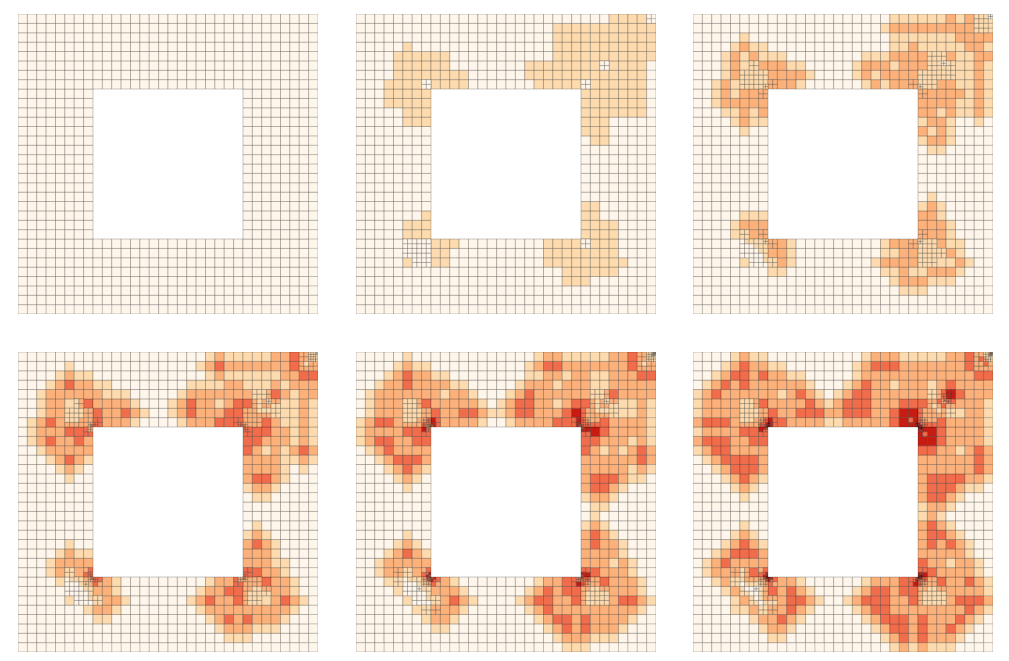

([source: Deal.II step 27](https://dealii.org/developer/doxygen/deal.II/step_27.html))

# What meshes do engineers use?

<img src="https://images.ansys.com/is/image/ansys/fundamentals-of-fea-meshing-cages-motorcycle-pump?&wid=866&op_usm=0.9,1.0,20,0&fit=constrain,0" width="100%" />

[source: Ansys blog](https://www.ansys.com/blog/fundamentals-of-fea-meshing-for-structural-analysis)

## Test problem

<video src="figures/ratel/one-hole-traction-20220222.webm" autoplay controls loop />

# Approximation constants are good for high order

<img src="figures/ratel/accuracy_study_annotated.svg" width="90%" />

# Bandwidth is scarce compared to flops

<img src="figures/karlrupp/flop-per-byte-dp-2022.svg" width="90%" class="center" />

# Why matrix-free?
* Assembled matrices need at least 4 bytes transferred per flop. Hardware does 10 flops/byte. Matrix-free methods store and move less data, compute faster.

<img src="figures/TensorVsAssembly-qstore.svg" width="90%" class="center" />

# Matrix-free is already faster for $Q_1$ elements

<img src="figures/ratel/schwarz-apply.svg" width="90%" />

# $p$-multigrid algorithm and cost breakdown

<img src="figures/ratel/p-mg-cycle.png" width="80%" />

<img src="figures/ratel/op_schematic.svg" width="80%" />

In [30]:
IFrame("figures/ratel/schwarz-q2-flame.svg", width="2000", height="350")

# Nonlinear solve efficiency

## $Q_2$ elements
<img src="figures/ratel/schwarz-q2-t20-r2-l2-SNESSolve.svg" />

## $Q_3$ elements
<img src="figures/ratel/schwarz-q3-t20-r2-l1-SNESSolve.svg" />

# Linear solve efficiency

## $Q_2$ elements
<img src="figures/ratel/schwarz-q2-t20-r2-l2-KSPSolve.svg" />

## $Q_3$ elements
<img src="figures/ratel/schwarz-q3-t20-r2-l1-KSPSolve.svg" />

* Coarse solver is hypre BoomerAMG tuned configured for elasticity; thanks Victor Paludetto
Magri.

# Preconditioner setup efficiency

## $Q_2$ elements
<img src="figures/ratel/schwarz-q2-t20-r2-l2-PCSetUp.svg" />

## $Q_3$ elements
<img src="figures/ratel/schwarz-q3-t20-r2-l1-PCSetUp.svg" />

# Half-inch puck (F67), 50 MDoF, quadratic tets

<img src="figures/micromorph/f67-detail.png" width="100%" />

* 40k grains segmented from CT scans
* 1% global strain, neo-Hookean model
* 34 seconds per nonlinear solve (`rtol=1e-8`)
  * 7 seconds per linear solve
  * 45 CG iterations
* `/gpu/hip/shared` backend since `hip/gen` does not yet support tensor product elements
  * Will try `hip/magma`
* BoomerAMG coarse solve (linear elements)
* Pure-GPU assembly into hypre ParCSR

In [28]:
IFrame("figures/micromorph/flamegraph-tioga-f67-puck.svg", width="1400", height="200")

# Phase-field damage mechanics

$$
\begin{bmatrix}
A & B \\
C & D
\end{bmatrix}
\begin{bmatrix} \mathbf u \\ \phi \end{bmatrix}
=
\begin{bmatrix} \mathbf b \\ \mathbf 0 \end{bmatrix}
$$
* $A$ is elasticity operator
* $D$ is screened Laplacian for damage (Green's functions decay in a few elements)

## p-MG setup

* p-MG coarsen from quadratic to linear elements (tets in this example)
* specify 6-dimensional rigid body modes as near null space
* damage field $\phi$ is not needed in AMG
* optional: point-block Jacobi smoothing

<video src="figures/ratel/luke-damage-Gc-ratio-20.webm" autoplay loop width="100%" />

<video src="figures/ratel/luke-sigmaxx-Gc-ratio-20.webm" autoplay loop width="100%" />

# One node of Crusher vs historical Gordon Bell
* 184 MDoF $Q_2$ elements nonlinear analysis in seconds

### 2002 Gordon Bell (Bhardwaj et al)

<img src="figures/ratel/gordon-bell-2002-mems.png" width="70%" />

<img src="figures/ratel/gordon-bell-2002-mems-table.png" width="100%" />

### 2004 Gordon Bell (Adams et al)

<img src="figures/ratel/gordon-bell-2004-bone.png" width="70%" />

<img src="figures/ratel/gordon-bell-2004-bone-scaling.jpg" width="100%" />

# Comparison

<img src="figures/ratel/gordon-bell-2004-bone.png" width="70%" />

<img src="figures/ratel/schwarz-q2-8x8x8-t20-l2-r2.png" width="50%" class="center" />

| Metric | Adams et al 2004 | Ratel | Ratel |
|---|---|---|---|
| Discretization | linear | quadratic | cubic |
| Machine | ASCI White 130 nodes | Crusher 1 node | Crusher 1 node |
| Peak Bandwidth | 1.56 TB/s | 12 TB/s | 12 TB/s |
| Degrees of freedom | 237 M | 184 M | 331 M |
| kDoF/GB | 460 | 400 | 700 |
| load step strain | 0.5% | 12% | 12% |
| kDoF/s per load step | 600 | 6000 | 5500 |

# Same story for compressible turbulence

<img src="figures/Boeing_A2_isoQspeed2_lowRes.png" width="100%" />

<video src="figures/fluids/ROPI_OutView.webm" autoplay loop />

## PHASTA

* Extreme-scale unstructured CFD, Fortran
* SUPG, implicit (gen-$\alpha$) Newton-Krylov
* Aurora ESP: 2y on the "Intel/ALCF plan"
  * GPU still slower than CPU

## CEED-PHASTA

* New implementation in libCEED with PETSc
* Matrix-free cuts setup/helps strong scaling
* End-to-end GPU

| Code | Arch | Element | second/step |
|---|---|---|---|
| PHASTA | Skylake | $Q_1$ | 6-12 |
| CEED | A100 | $Q_1$ | 1.0 |
| CEED | A100 | $Q_2$ | 0.7 |
| CEED | A100 | $Q_3$ | 0.5 |

# Algorithmic framework

* SUPG/VMS for compressible NS in pressure-primitive variables
* Implicit integration using gen-$\alpha$
* 3 Newton iterations per time step
  * First two are very cheap (5-15 Krylov iterations), third is stiffer

<img src="figures/fluids/libceed-stored-jacobian-james.png" />

* Benchmark
  * flat plate $Re_\theta \approx 970$ STG inflow
  * $Ma \approx 0.1$
  * 12-30 nominal span/steamline resolution (plus units)

<img src="figures/fluids/libceed-apply-polaris-james.png" />

* 10 nodes of Polaris (4x A100/node)
* 250k nodes (1.25 MDoF) per GPU

# Boeing Speed Bump

<img src="figures/fluids/speed-bump-3d.png" />

* "Easy" problem for which RANS prediction of separation is catastrophic.
* Good experimental data available
* What is missing/needed in new RANS models:

> Can a RANS model predict a high-lift flow for the right reasons?

<img src="figures/fluids/speed-bump-Cp-Cf-rans-dns.png" class="center" />

# Are structured grids dead?

## Uzun and Malik (2022)

* Prefactored 4th order compact FD
* up to 10th order compact filtering
* Subcycled implicit time integration

<img src="figures/fluids/UzunMalik-BumpVorticity-2022.png" />

### A tale of two bumps, $\mathrm{Re}_L = 2M, \mathrm{Ma} = 0.1$

| Property | Uzun & Malik | Balin & Jansen |
|---|---|---|
| Grid | overset FD | tet/prism FE |
| Domain width | 0.04L | 0.08L |
| # points | 10B | 4B |
| steps needed | 1969k | 154k |
| seconds/step | 1.4 | 12 |
| cores (nodes) | 40k (1000) | 39k (972) |
| days | 33 | 25 |
| Wall normal spacing ($+$ units) | 0.6 | 0.3 |
| Mach number | 0.2 | incompressible |

* $\Delta t$ incompressible $\approx 2 \Delta t$ compressible

# Fluids outlook

<img src="figures/fluids/flat-plate-validation-1410.png" />

* Data-driven subgrid stress model (Prakash, Jansen, Evans)
  * Online training using SmartSim
  * Reference frame and unit invariant

* Speed Bump $Re_L = 2M$
  * Determine DNS resolution for cubic elements
  * Hex-dominant mixed topology meshing adapted to Kolmogorov scale
  * Goal: reduce 30-40 days to 3 days on Aurora
* DDES/Hybrid for real geometry (e.g., HLPW)
* Fundamental numerics
  * Optimized dispersion: stabilization and basis
  * Low-Mach preconditioning, time integration

## [libCEED](https://libceed.readthedocs.io): fast algebra for finite elements

* Backend plugins with run-time selection
  * debug/memcheck, optimized
  * libxsmm, CUDA, HIP
  * MAGMA to CUDA and HIP
  * OCCA to OpenMP, OpenCL, CUDA, and HIP
* Single source vanilla C for QFunctions
  * Easy to debug, understand locally, C++ optional
  * Target for DSLs, AD
* Python, Julia, Rust
* 2-clause BSD
* Available via MFEM, PETSc, Nek5000

<img src="figures/ceed/libCEEDBackends.svg" width="100%" />

Thanks to many developers, including Jeremy Thompson, Yohann Dudouit, Valeria Barra, Natalie Beams,  Ahmad Abdelfattah, Leila Ghaffari, Will Pazner, Thilina Ratnayaka, Tzanio Kolev, Veselin Dobrev, David Medina

<img src="figures/ceed/libCEED-2.png" width=100% />


# Old vs new performance models

## Iterative solvers: Bandwidth
* SpMV arithmetic intensity of 1/6 flop/byte
* Preconditioners also mostly bandwidth
  * Architectural latency a big problem on GPUs, especially for sparse triangular solves.
  * Sparse matrix-matrix products for AMG setup
  
## Direct solvers: Bandwidth and Dense compute
* Leaf work in sparse direct solves
* Dense factorization of supernodes
  * Fundamentally nonscalable, granularity on GPUs is already too big to apply on subdomains
* Research on H-matrix approximations (e.g., in STRUMPACK)

## New model: Still mostly bandwidth

* Reduce storage needed at quadrature points
  * Half the cost of a sparse matrix already for linear elements
  * Big efficiency gains for high order
* Assembled coarse levels are much smaller.

## Compute

* Kernel fusion is necessary
* Balance vectorization with cache/occupancy
* $O(n)$, but benefits from BLIS-like abstractions
| BLIS | libCEED |
|------|---------|
| packing | batched element restriction |
| microkernel | basis action |
| ? | user-provided qfunctions |


# Modeling principles for matrix-free methods

## Seek well-conditioned formulations

* Nitsche contact vs Lagrange multipliers or penalties
* Conforming discretizations vs XFEM and immersed boundary
* Mixed FE vs displacement-only elasticity

## Smooth everything

* Leave extra degrees of freedom in
  * Skip static condensation
* Approx Braess-Sarazin vs segregated MG vs Vanka vs vertex-star vs BDDC
* "optimal" asymptotics must be weighted against implementation efficiency

# Outlook: [petsc.org](https://petsc.org) [libceed.org](https://libceed.org) [ratel.micromorph.org](https://ratel.micromorph.org)

* You can move from $Q_1$ to $Q_2$ elements for about 2x cost (despite 8x more DoFs); $p>2$ is free
* Mesh to resolve geometry, $p$-refine to pragmatic accuracy (tools!)
* libCEED already offers 2x speedup for $Q_1$
* Gordon Bell scale from 20 years ago $\mapsto$ interactive on a workstation (if you can buy MI250X 😊)

## Simplifying philosophy
* Embrace nonlinearity (hyperelastic, compressible NS, ...) and let the solver converge fast when a simpler model is valid.
  * Caveat: when nonlinearity resolves more scales (e.g., RANS vs scale-resolving)
* Just embrace unstructured meshes.

## Thanks: DOE ECP, DOE ASCR, DOE PSAAP, NSF CISE

<video src="figures/ratel/schwarz-pendulum.webm" autoplay loop width="60%" />

<video src="figures/fluids/ROPI_OutView.webm" autoplay loop width="80%" />